Copyright 2018 The Dopamine Authors.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Dopamine: How to create and train a custom agent

This colab demonstrates how to create a variant of a provided agent (Example 1) and how to create a new agent from
scratch (Example 2).

Run all the cells below in order.

In [0]:
# @title Install necessary packages.
!pip install --upgrade --no-cache-dir dopamine-rl
!pip install cmake
!pip install atari_py

In [0]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.agents.dqn import dqn_agent
from dopamine.atari import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags

BASE_PATH = '/tmp/colab_dope_run'  # @param
GAME = 'Asterix'  # @param

In [0]:
# @title Load baseline data
!gsutil -q -m cp -R gs://download-dopamine-rl/preprocessed-benchmarks/* /content/
experimental_data = colab_utils.load_baselines('/content')

## Example 1: Train a modified version of DQN
Asterix is one of the standard agents provided with Dopamine.
The purpose of this example is to demonstrate how one can modify an existing agent. The modification
we are doing here (choosing actions randomly) is for illustrative purposes: it will clearly perform very
poorly.

In [8]:
# @title Create an agent based on DQN, but choosing actions randomly.

LOG_PATH = os.path.join(BASE_PATH, 'random_dqn', GAME)

class MyRandomDQNAgent(dqn_agent.DQNAgent):
  def __init__(self, sess, num_actions):
    """This maintains all the DQN default argument values."""
    super(MyRandomDQNAgent, self).__init__(sess, num_actions)
    
  def step(self, reward, observation):
    """Calls the step function of the parent class, but returns a random action.
    """
    _ = super(MyRandomDQNAgent, self).step(reward, observation)
    return np.random.randint(self.num_actions)

def create_random_dqn_agent(sess, environment):
  """The Runner class will expect a function of this type to create an agent."""
  return MyRandomDQNAgent(sess, num_actions=environment.action_space.n)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework. We also explicitly terminate after 110 iterations (instead
# of the standard 200) to demonstrate the plotting of partial runs.
random_dqn_runner = run_experiment.Runner(LOG_PATH,
                                          create_random_dqn_agent,
                                          game_name=GAME,
                                          num_iterations=200,
                                          training_steps=10,
                                          evaluation_steps=10,
                                          max_steps_per_episode=100)

INFO:tensorflow:Creating MyRandomDQNAgent agent with the following parameters:
INFO:tensorflow:	 gamma: 0.990000
INFO:tensorflow:	 update_horizon: 1.000000
INFO:tensorflow:	 min_replay_history: 20000
INFO:tensorflow:	 update_period: 4
INFO:tensorflow:	 target_update_period: 8000
INFO:tensorflow:	 epsilon_train: 0.010000
INFO:tensorflow:	 epsilon_eval: 0.001000
INFO:tensorflow:	 epsilon_decay_period: 250000
INFO:tensorflow:	 tf_device: /cpu:*
INFO:tensorflow:	 use_staging: True
INFO:tensorflow:	 optimizer: <tensorflow.python.training.rmsprop.RMSPropOptimizer object at 0x7f9e61fd5128>
INFO:tensorflow:Creating a OutOfGraphReplayBuffer replay memory with the following parameters:
INFO:tensorflow:	 observation_shape: 84
INFO:tensorflow:	 stack_size: 4
INFO:tensorflow:	 replay_capacity: 1000000
INFO:tensorflow:	 batch_size: 32
INFO:tensorflow:	 update_horizon: 1
INFO:tensorflow:	 gamma: 0.990000


In [0]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
random_dqn_runner.run_experiment()
print('Done training!')

In [0]:
# @title Load the training logs.
random_dqn_data = colab_utils.read_experiment(LOG_PATH, verbose=True)
random_dqn_data['agent'] = 'MyRandomDQN'
random_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(random_dqn_data,
                                                        how='outer')

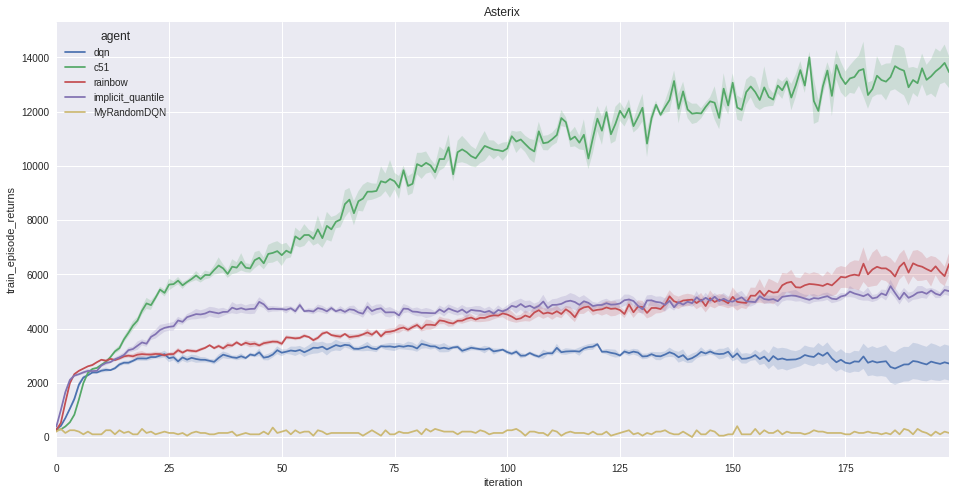

In [11]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.tsplot(data=experimental_data[GAME], time='iteration', unit='run_number',
           condition='agent', value='train_episode_returns', ax=ax)
plt.title(GAME)
plt.show()

## Example 2: Train an agent built from scratch.
The purpose of this example is to demonstrate how one can create an agent from scratch. The agent
created here is meant to demonstrate the bare minimum functionality that is expected from agents. It is
selecting actions in a very suboptimal way, so it will clearly do poorly.

In [0]:
# @title Create a completely new agent from scratch.

LOG_PATH = os.path.join(BASE_PATH, 'sticky_agent', GAME)

class StickyAgent(object):
  """This agent randomly selects an action and sticks to it. It will change
  actions with probability switch_prob."""
  def __init__(self, sess, num_actions, switch_prob=0.1):
    self._sess = sess
    self._num_actions = num_actions
    self._switch_prob = switch_prob
    self._last_action = np.random.randint(num_actions)
    self.eval_mode = False
    
  def _choose_action(self):
    if np.random.random() <= self._switch_prob:
      self._last_action = np.random.randint(self._num_actions)
    return self._last_action
    
  def bundle_and_checkpoint(self, unused_checkpoint_dir, unused_iteration):
    pass
    
  def unbundle(self, unused_checkpoint_dir, unused_checkpoint_version,
               unused_data):
    pass
  
  def begin_episode(self, unused_observation):
    return self._choose_action()
  
  def end_episode(self, unused_reward):
    pass
  
  def step(self, reward, observation):
    return self._choose_action()
  
def create_sticky_agent(sess, environment):
  """The Runner class will expect a function of this type to create an agent."""
  return StickyAgent(sess, num_actions=environment.action_space.n,
                     switch_prob=0.2)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework. We also explicitly terminate after 110 iterations (instead
# of the standard 200) to demonstrate the plotting of partial runs.
sticky_runner = run_experiment.Runner(LOG_PATH,
                                      create_sticky_agent,
                                      game_name=GAME,
                                      num_iterations=200,
                                      training_steps=10,
                                      evaluation_steps=10,
                                      max_steps_per_episode=100)

In [0]:
# @title Train StickyAgent.
print('Will train sticky agent, please be patient, may be a while...')
sticky_runner.run_experiment()
print('Done training!')

In [0]:
# @title Load the training logs.
sticky_data = colab_utils.read_experiment(log_path=LOG_PATH, verbose=True)
sticky_data['agent'] = 'StickyAgent'
sticky_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(sticky_data,
                                                        how='outer')

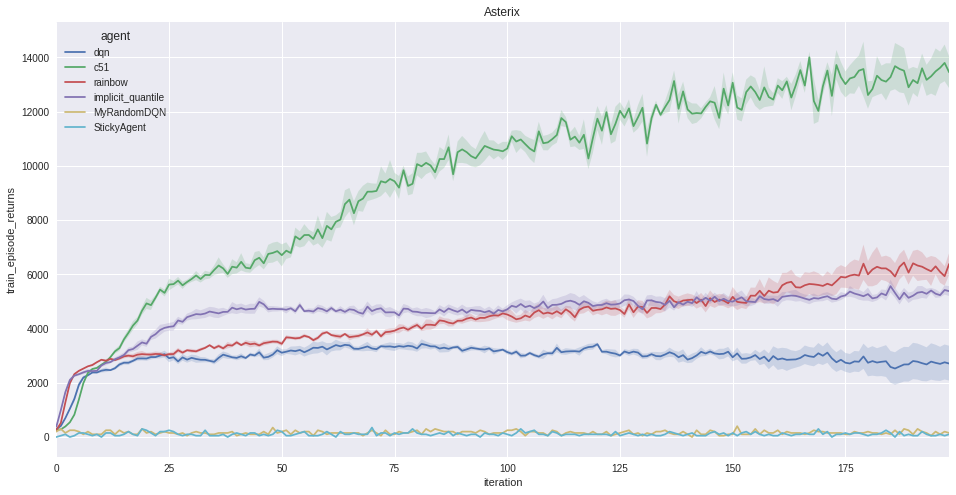

In [27]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.tsplot(data=experimental_data[GAME], time='iteration', unit='run_number',
           condition='agent', value='train_episode_returns', ax=ax)
plt.title(GAME)
plt.show()